In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller, pacf

/home/abhishek/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Predicting solar output

### Loading data

In [2]:
solar_train_actual = pd.read_csv('./Processed Data/Solar_Train.csv', header=None)
solar_train_oracle = pd.read_csv('./Processed Data/Solar_Train_pred.csv', header=None)

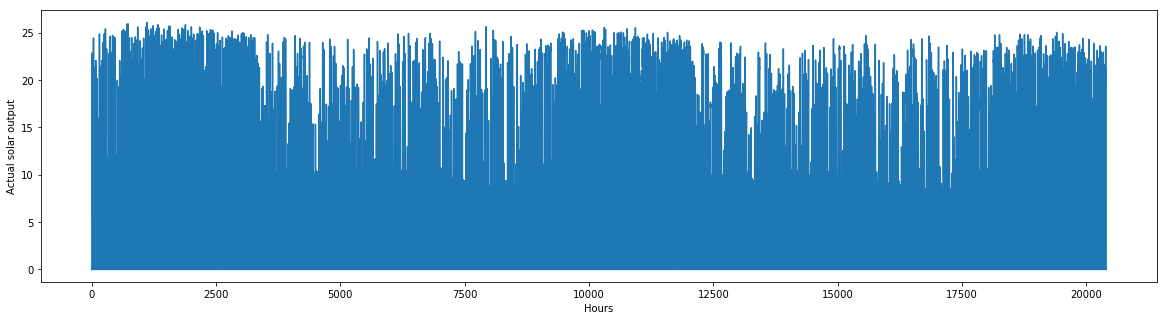

In [3]:
series = solar_train_actual.values.flatten()
plt.figure(figsize=(20,5))
plt.plot(series)
plt.xlabel('Hours')
plt.ylabel('Actual solar output')
plt.show()

### Determining stationarity

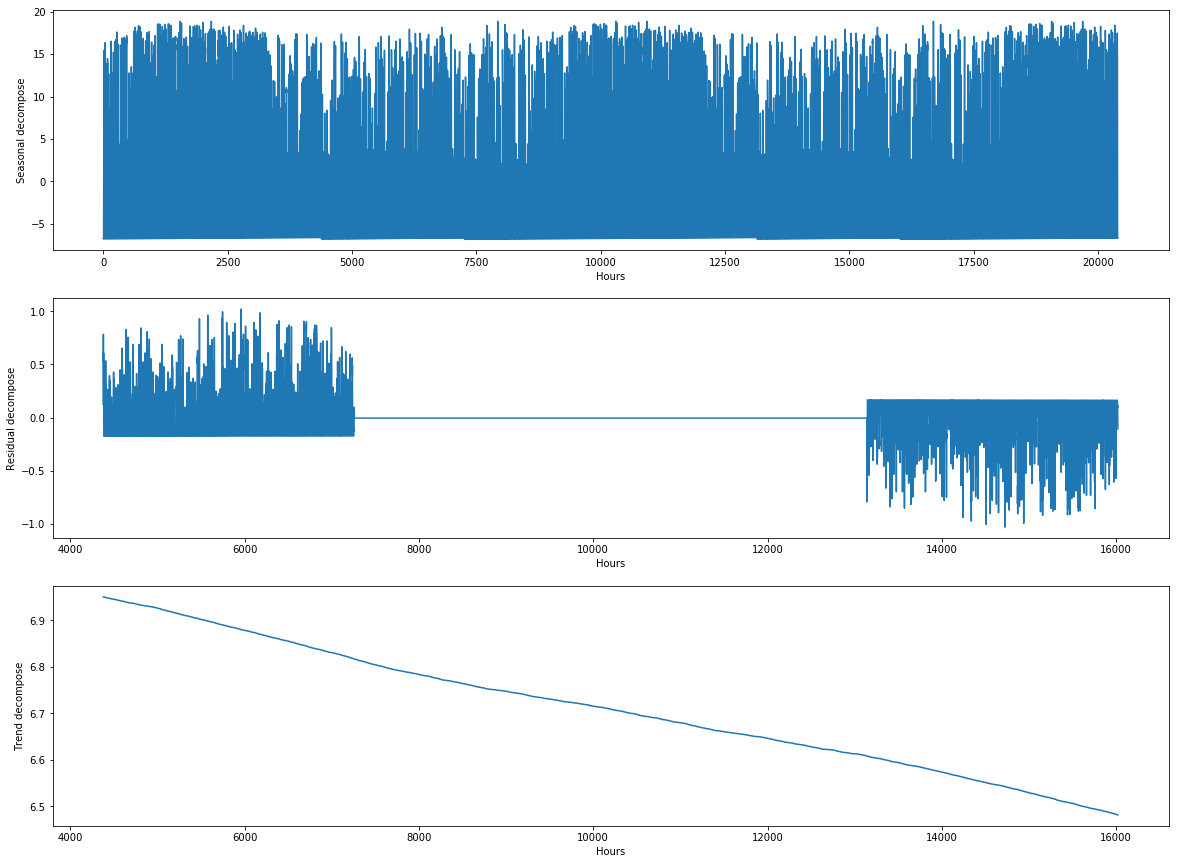

In [4]:
decompose = seasonal_decompose(series, freq=365*24, model='additive')

plt.figure(figsize=(20, 15))
plt.subplot(311)
plt.xlabel('Hours')
plt.ylabel('Seasonal decompose')
plt.plot(decompose.seasonal)

plt.subplot(312)
plt.xlabel('Hours')
plt.ylabel('Residual decompose')
plt.plot(decompose.resid)

plt.subplot(313)
plt.xlabel('Hours')
plt.ylabel('Trend decompose')
plt.plot(decompose.trend)
plt.show()

We can clearly see that there is a clearly seasonality in the given time series. 

In [5]:
pd.Series(series).diff(365 * 24).dropna().abs().describe()

count    11640.000000
mean         0.353004
std          0.562387
min          0.000000
25%          0.000000
50%          0.000000
75%          0.550000
max          2.500000
dtype: float64

The above table describes the absolute difference in solar output for days in two consecutive years. Clearly, the time series is seasonal with period 1 year.

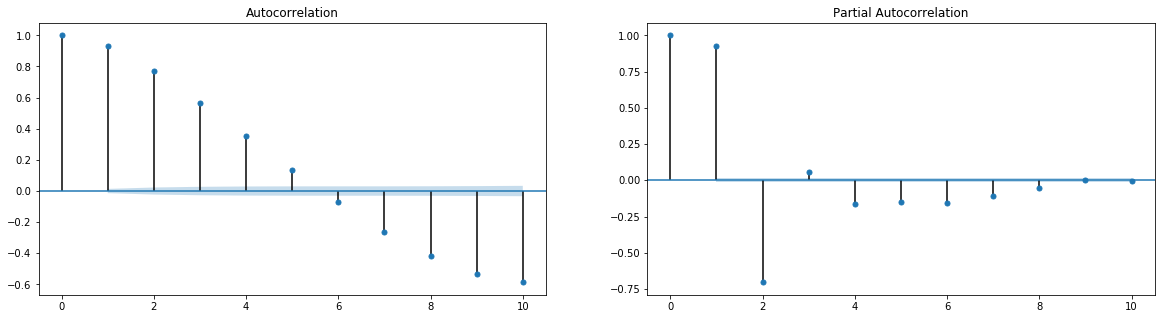

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))

fig = plot_acf(series, ax=axes[0],lags=10)
fig = plot_pacf(series, ax=axes[1],lags=10)

On plotting the ACF and PACF plots we observe that ACF series never stabilises. Clearly the series is not stationary and we have to remove seasonality to make it stationary.

### Removing seasonality

In [7]:
series = pd.Series(series).diff(24*365).dropna()

We remove seasonality and model this series now.

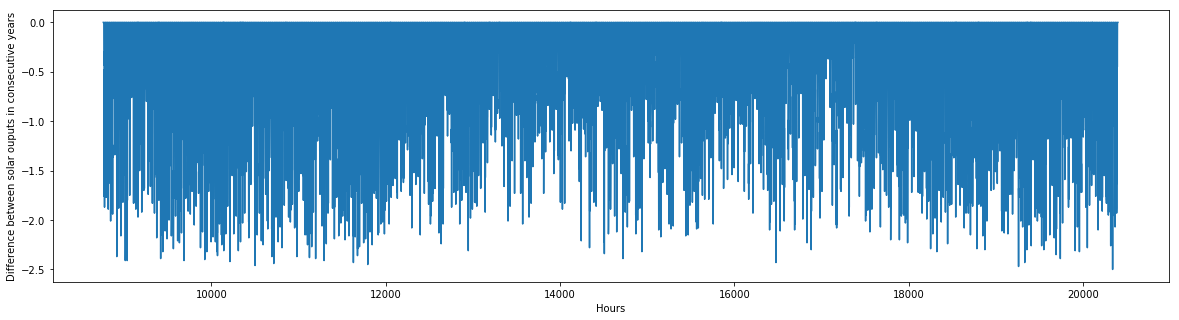

In [8]:
plt.figure(figsize=(20, 5))
plt.xlabel('Hours')
plt.ylabel('Difference between solar ouputs in consecutive years')
plt.plot(series)
plt.show()

Clearly this series show periodicity and is not cyclic. ACF and PACF plots further support our claim.

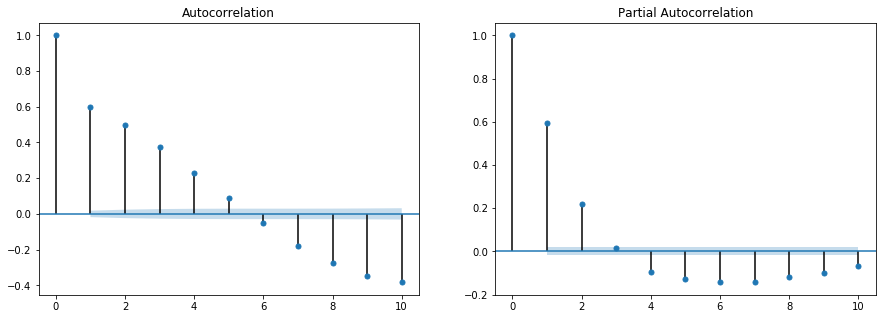

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig = plot_acf(series, ax=axes[0],lags=10)
fig = plot_pacf(series, ax=axes[1],lags=10)

We now plot the further differenced series and observe its ACF and PACF plots.

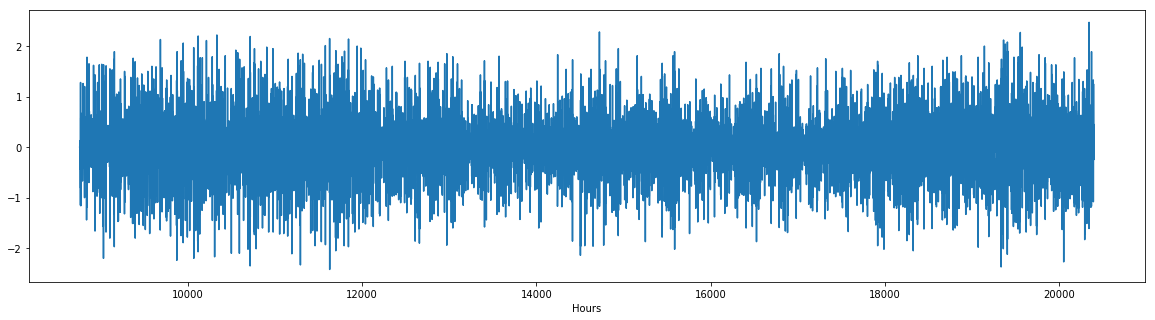

In [10]:
plt.figure(figsize=(20, 5))
plt.xlabel('Hours')
plt.plot(series.diff().dropna())
plt.show()

Clearly this series is stationary, ACF and PACF plots further support this claim.

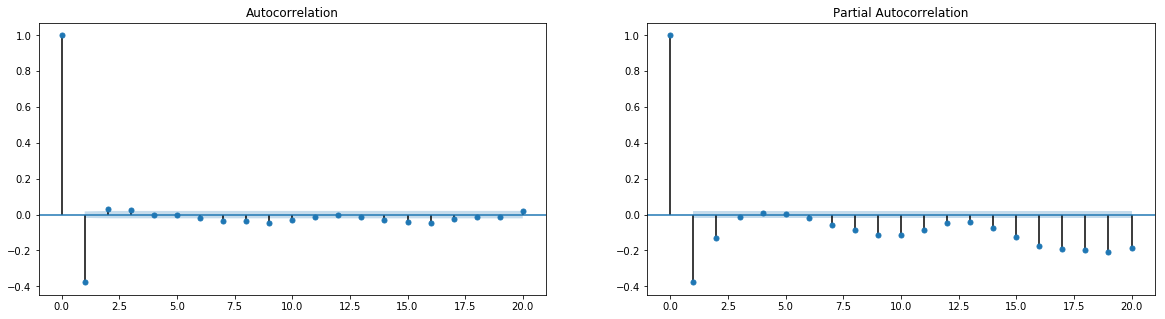

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

fig = plot_acf(series.diff().dropna(), ax=axes[0], lags=20)
fig = plot_pacf(series.diff().dropna(), ax=axes[1], lags=20)

This series though is stationary looks particularly over differenced. Therefore, we will make two models, one differenced and one not differenced. For more details refer to [here](http://people.duke.edu/~rnau/411arim3.htm).

In [12]:
model = ARIMA(series.values, order=(2, 0, 5))
model_fit = model.fit(trend='c')
print(model_fit.summary())

/home/abhishek/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                11640
Model:                     ARMA(2, 5)   Log Likelihood               -5498.402
Method:                       css-mle   S.D. of innovations              0.388
Date:                Fri, 15 Dec 2017   AIC                          11014.804
Time:                        18:10:41   BIC                          11081.064
Sample:                             0   HQIC                         11037.065
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3549   3.08e-06  -1.15e+05      0.000      -0.355      -0.355
ar.L1.y        1.9319   2.03e-05   9.53e+04      0.000       1.932       1.932
ar.L2.y       -1.0000        nan        nan        n

/home/abhishek/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/abhishek/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/abhishek/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/abhishek/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [13]:
model = ARIMA(series.values, order=(2, 1, 3))
model_fit1 = model.fit(trend='nc')
print(model_fit1.summary())

/home/abhishek/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/abhishek/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                11639
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -5802.725
Method:                       css-mle   S.D. of innovations              0.398
Date:                Fri, 15 Dec 2017   AIC                          11617.449
Time:                        18:10:55   BIC                          11661.622
Sample:                             1   HQIC                         11632.290
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y      1.9317      0.000   1.76e+04      0.000       1.932       1.932
ar.L2.D.y     -0.9999   9.91e-05  -1.01e+04      0.000      -1.000      -1.000
ma.L1.D.y     -2.8954      0.007   -431.260      0.0

Clearly the first model fits better (see log likelihood). Therefore we will be using it to make our prediction.

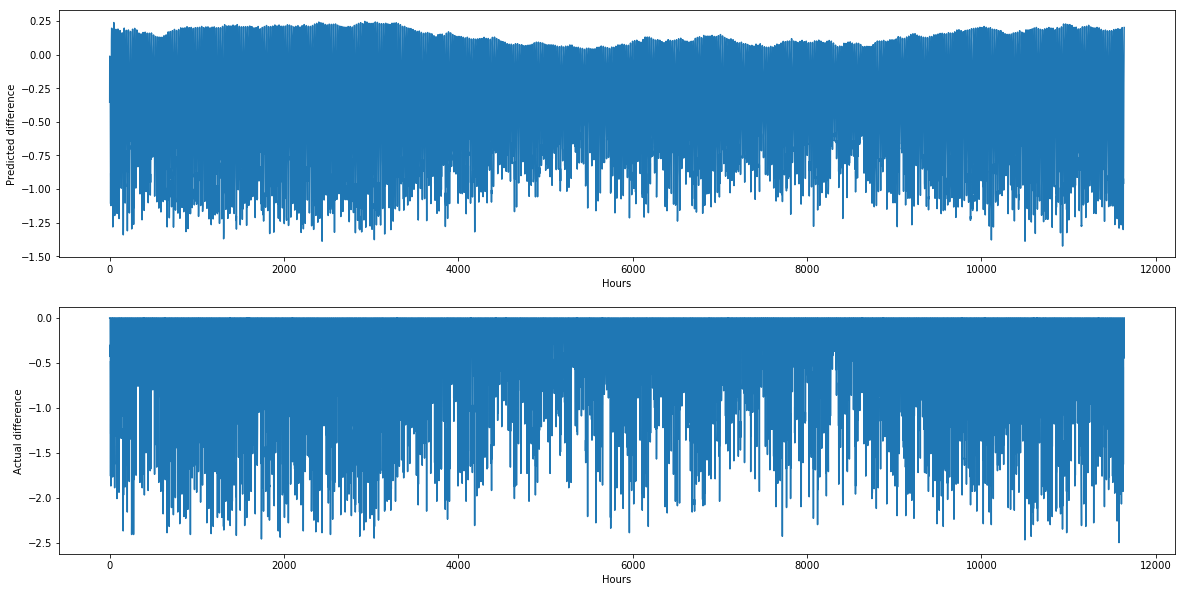

In [14]:
plt.figure(figsize=(20, 10))

plt.subplot(211)
plt.xlabel('Hours')
plt.ylabel('Predicted difference')
plt.plot(model_fit.fittedvalues)

plt.subplot(212)
plt.xlabel('Hours')
plt.ylabel('Actual difference')
plt.plot(series.values)

plt.show()

Now we forecast the value of difference in solar output for two consecutive years for the next 50 days and add the value of solar output of previous year to obtain the predicted values of solar output for next 50 days.

In [15]:
solar_val_pred = model_fit.predict(start=11640, end=11640 + 24 * 50 - 1) + solar_train_actual.values.flatten()[-365 * 24:-365 * 24+50*24]
solar_val_pred = solar_val_pred.reshape((50, 24))

### Comparing our prediction with oracle's for solar output

In [16]:
solar_val_actual = pd.read_csv('./Processed Data/Solar_Val.csv', header=None)
solar_val_oracle = pd.read_csv('./Processed Data/Solar_Val_pred.csv', header=None)

In [17]:
result = pd.concat([pd.DataFrame((solar_val_pred - solar_val_actual).abs().values.flatten()).describe(), pd.DataFrame((solar_val_oracle - solar_val_actual).abs().values.flatten()).describe()], axis=1)
result.columns = ['Absolute difference of predicted and actual solar output', 'Absolute difference of oracle\'s prediction and actual solar output']

In [18]:
pd.options.display.float_format = '{:.4f}'.format
result

,Absolute difference of predicted and actual solar output,Absolute difference of oracle's prediction and actual solar output
count,1200.0000,1200.0000
mean,0.3090,0.5131
std,0.2577,0.7809
min,0.0010,0.0000
25%,0.1373,0.0000
50%,0.2484,0.0000
75%,0.3919,0.8500
max,1.4226,3.2600


# Predicting Market price

## Approach 1

Our first approach to predict market price is to model the difference between actual and oracle's prediction for market price. After fitting the model and subsequently forecasting the difference we add it to oracle's prediction for market price to get our prediction.

### Loading series

In [19]:
price_train_actual = pd.read_csv('./Processed Data/Price_Train.csv', header=None)
price_train_oracle = pd.read_csv('./Processed Data/Price_Train_pred.csv', header=None)

In [20]:
series = (price_train_actual - price_train_oracle).values.copy().flatten()

### Plotting the series

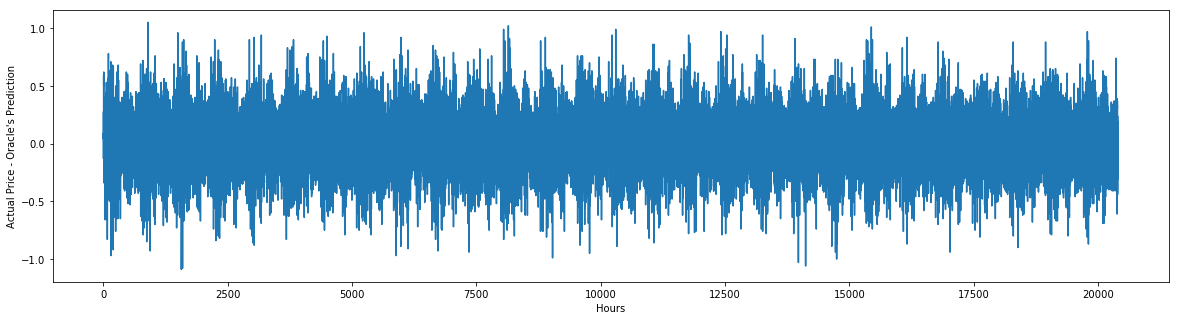

In [21]:
plt.figure(figsize=(20,5))
plt.plot(series)
plt.xlabel('Hours')
plt.ylabel('Actual Price - Oracle\'s Prediction')
plt.show()

### Determining stationarity

/home/abhishek/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/abhishek/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


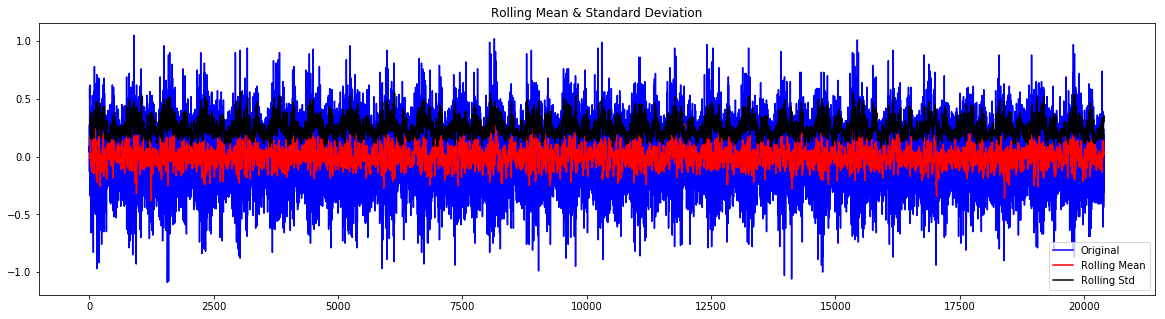

Results of Dickey-Fuller Test:
Test Statistic                  -36.5942
p-value                           0.0000
#Lags Used                       14.0000
Number of Observations Used   20385.0000
Critical Value (1%)              -3.4307
Critical Value (5%)              -2.8617
Critical Value (10%)             -2.5668
dtype: float64


In [22]:
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    # Plot rolling statistics:
    plt.figure(figsize=(20,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(series)

As test statistic is way less than critical value, the series is stationary. For more details refer to third point [here](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python).

### Determining AR and MA values.

In [23]:
lag_acf = acf(series, nlags=20)
lag_pacf = pacf(series, nlags=20, method='ols')

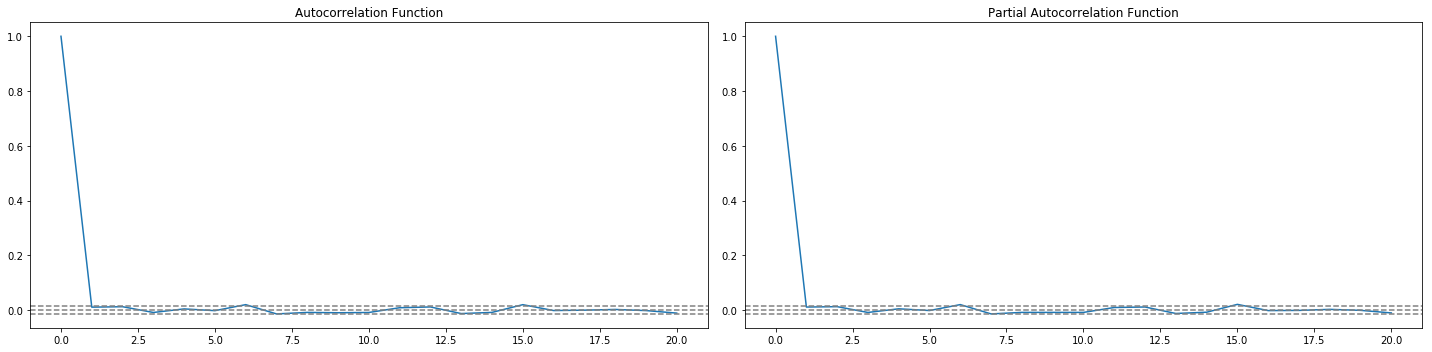

In [24]:
# Plot ACF: 
plt.figure(figsize=(20,5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

As the lag value where the PACF chart crosses the upper confidence interval for the first time is **2**, p = 2.  
As the lag value where the ACF chart crosses the upper confidence interval for the first time is **2**, q = 2.


For more details refer to the fifth point [here](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/).

### Fitting the model

In [25]:
model = ARIMA(series, order=(2,0,2))
model_fit = model.fit()

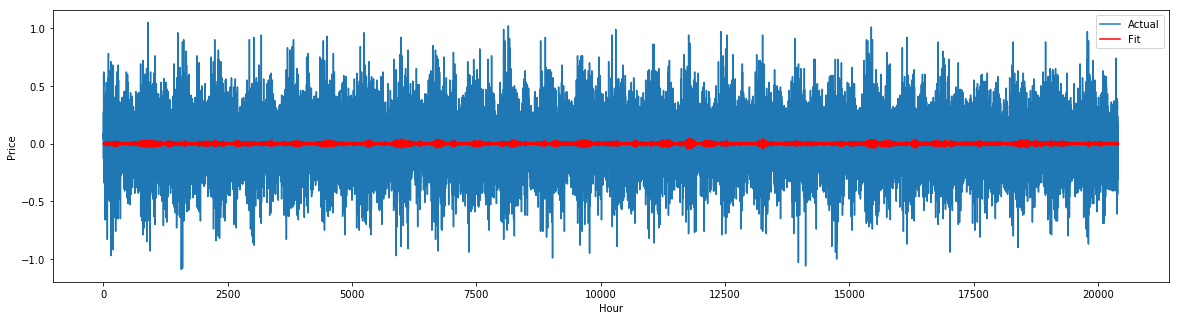

In [26]:
plt.figure(figsize=(20,5))
plt.plot(series, label='Actual')
plt.plot(model_fit.fittedvalues, color='red', label='Fit')
plt.legend(loc='best')
plt.xlabel('Hour')
plt.ylabel('Price')
plt.show()

As we can see the model does very poorly to predict the time series.

#### Plotting residual errors

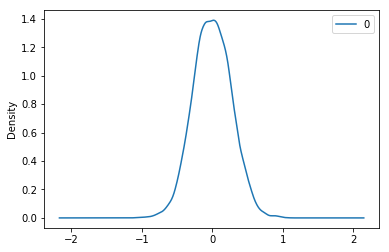

,0
count,20400.0000
mean,-0.0000
std,0.2719
min,-1.0907
25%,-0.1854
50%,-0.0032
75%,0.1856
max,1.0700


In [27]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
plt.show()
residuals.describe()

### Forecasting for next 50 days

In [28]:
price_val_oracle = pd.read_csv('./Processed Data/Price_Val_pred.csv', header=None)
price_val_pred = price_val_oracle + pd.DataFrame(model_fit.predict(20400, 20400 + 50 * 24 - 1).reshape((50, 24)))

### Comparing oracle's prediction with ours

In [29]:
price_val_actual = pd.read_csv('./Processed Data/Price_Val.csv', header=None)

In [30]:
result = pd.concat([pd.DataFrame((price_val_pred - price_val_actual).abs().values.flatten()).describe(), pd.DataFrame((price_val_oracle - price_val_actual).abs().values.flatten()).describe()], axis=1)
result.columns = ['Absolute difference of predicted and actual price', 'Absolute difference of oracle\'s prediction and actual price']

In [31]:
result

,Absolute difference of predicted and actual price,Absolute difference of oracle's prediction and actual price
count,1200.0000,1200.0000
mean,0.2271,0.2271
std,0.1661,0.1661
min,0.0007,0.0000
25%,0.1010,0.1000
50%,0.1896,0.1900
75%,0.3207,0.3200
max,0.9408,0.9400


## Approach 2
* In the training set's actual market price data, we first find the days with minimum market price for **HOUR 1** and denote them by **DAY 1**.
* Now for **DAY 1** to **DAY 31** we find the average market price for each hour.



* In test set's oracle's predicted market price data, we find the corresponding **DAY 1** by finding the day with minimum market price for **HOUR 1**.
* The predicted market price for the following days will be the average market price.

### Determining DAY 1 in actual data

In [32]:
day1_train_actual = list(price_train_actual[0][price_train_actual[0] < 0.8].index)

### Calculating average prices for DAY 1-31

In [33]:
average_price = []
for hour in range(24):
    number_occurence = np.zeros(31)
    sum_day = np.zeros(31)
    for i, j in zip(np.array(day1_train_actual)[:-1], (np.array(day1_train_actual))[1:]):
        sum_day[:j - i] += price_train_actual[hour][i:j].values
        number_occurence[:j - i] += np.ones(j - i)
    average_price.append(sum_day / number_occurence)

In [34]:
average_price = pd.DataFrame(np.array(average_price))

### Determining DAY 1 in oracle's prediction

In [35]:
day1_val_oracle = list(price_val_oracle[0][price_val_oracle[0] < 0.8].index)

### Manually formulating prediction

In [36]:
price_val_pred = pd.concat([average_price[list(range(31))[-1 * day1_val_oracle[0] - 1:-1]], average_price[list(range(31))[:day1_val_oracle[1]-day1_val_oracle[0]]], average_price[list(range(31))[:50-day1_val_oracle[1]]]], axis=1)
price_val_pred.columns = np.arange(50)
price_val_pred = price_val_pred.T

### Comparing oracle's prediction with ours

In [37]:
result = pd.concat([pd.DataFrame((price_val_pred - price_val_actual).abs().values.flatten()).describe(), pd.DataFrame((price_val_oracle - price_val_actual).abs().values.flatten()).describe()], axis=1)
result.columns = ['Absolute difference of predicted and actual price', 'Absolute difference of oracle\'s prediction and actual price']

In [38]:
pd.options.display.float_format = '{:.4f}'.format
result

,Absolute difference of predicted and actual price,Absolute difference of oracle's prediction and actual price
count,1200.0000,1200.0000
mean,0.1678,0.2271
std,0.2345,0.1661
min,0.0000,0.0000
25%,0.0303,0.1000
50%,0.0794,0.1900
75%,0.1923,0.3200
max,1.9875,0.9400
